In [1]:
import warnings
import collections
import nest_asyncio
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_recommenders as tfrs

from typing import Optional, List, Tuple, Dict, Text
from models.movie_lens import MovieRecommender
from utils import load_data, create_tf_datasets, split_tf_datasets

warnings.filterwarnings('ignore')

In [2]:
nest_asyncio.apply()

In [10]:
ratings, movies, users = load_data()

In [11]:
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['movie_id'] = ratings['movie_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(float)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [12]:
movies['movie_id'] = movies['movie_id'].astype(int)
movies.head()

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [13]:
movie_ratings = ratings.merge(movies, how='left', on='movie_id')
movie_ratings.head()

,user_id,movie_id,rating,timestamp,movie_title
0,196,242,3.0,881250949,Kolya (1996)
1,186,302,3.0,891717742,L.A. Confidential (1997)
2,22,377,1.0,878887116,Heavyweights (1994)
3,244,51,2.0,880606923,Legends of the Fall (1994)
4,166,346,1.0,886397596,Jackie Brown (1997)


In [ ]:
class RatingAccuracy(tf.keras.metrics.Mean):
    
    def __init__(self, name: str = 'rating_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        
    def update_state(
        self, y_true: tf.Tensor, y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None
    ):
        absolute_diffs = tf.abs(y_true - y_pred)
        example_accuracies = tf.less_equal(absolute_diffs, 0.5)
        super().update_state(example_accuracies, sample_weight=sample_weight)

In [25]:
def create_tf_datasets(
    ratings_df: pd.DataFrame,
    batch_size: int = 1,
    max_examples_per_user: Optional[int] = None,
    max_clients: Optional[int] = None
) -> List[tf.data.Dataset]:
    """Creates TF Datasets containing the movies and ratings for all users."""
    if max_clients is not None:
        num_users = min(len(ratings_df.user_id.unique()), max_clients)
        
    def rating_batch_map_fn(rating_batch):
        """Maps a rating batch to an OrderedDict with tensor values."""
        return collections.OrderedDict([
            ("x", tf.cast(rating_batch[:, 0:2], tf.float32)),
            ("y", tf.cast(rating_batch[:, 2:3], tf.float32))
        ])

    tf_datasets = []
    for user_id in ratings_df.user_id.unique():
        user_ratings_df = ratings_df[ratings_df.user_id == user_id]

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings_df)
        tf_dataset = (
            tf_dataset.take(max_examples_per_user)
            .shuffle(buffer_size=max_examples_per_user, seed=42)
            .batch(batch_size)
            .map(rating_batch_map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )
        tf_datasets.append(tf_dataset)

    return tf_datasets

In [48]:
def split_tf_datasets(
    tf_datasets: List[tf.data.Dataset],
    train_fraction: float = 0.8,
    val_fraction: float = 0.1,
) -> Tuple[List[tf.data.Dataset], List[tf.data.Dataset], List[tf.data.Dataset]]:
    """Splits a list of user TF datasets into train/val/test by user."""
    np.random.seed(42)
    np.random.shuffle(tf_datasets)
            
    train_idx = int(len(tf_datasets) * train_fraction)
    val_idx = int(len(tf_datasets) * (train_fraction + val_fraction))
            
    return (
        tf_datasets[:train_idx], tf_datasets[train_idx:val_idx], tf_datasets[val_idx:]
    )

In [49]:
model_data = movie_ratings[['user_id', 'movie_id', 'rating']]
unique_user_ids = movie_ratings.user_id.unique()
unique_movie_ids = movie_ratings.movie_id.unique()

tf_data = create_tf_datasets(
    ratings_df=model_data,
    batch_size=5,
    max_examples_per_user=50,
    max_clients=2000
)

train_data, val_data, test_data = split_tf_datasets(tf_data)

In [85]:
def recommender_model_fn():
    inputs = tf.keras.Input(shape=(2,))
    user_embedding = tf.keras.layers.Embedding(len(unique_user_ids) + 1, 256)(inputs[:,0])
    user_embedding = tf.keras.layers.BatchNormalization()(user_embedding)
    user_embedding = tf.keras.layers.Dense(128, activation='relu')(user_embedding)
    user_embedding = tf.keras.layers.BatchNormalization()(user_embedding)
    user_embedding = tf.keras.layers.Dense(64, activation='relu')(user_embedding)
    user_embedding = tf.keras.layers.BatchNormalization()(user_embedding)
    user_embedding = tf.keras.layers.Dense(32, activation='relu')(user_embedding)
    user_embedding = tf.keras.layers.BatchNormalization()(user_embedding)

    movie_embedding = tf.keras.layers.Embedding(len(unique_movie_ids) + 1, 256)(inputs[:,1])
    movie_embedding = tf.keras.layers.BatchNormalization()(movie_embedding)
    movie_embedding = tf.keras.layers.Dense(128, activation='relu')(movie_embedding)
    movie_embedding = tf.keras.layers.BatchNormalization()(movie_embedding)
    movie_embedding = tf.keras.layers.Dense(64, activation='relu')(movie_embedding)
    movie_embedding = tf.keras.layers.BatchNormalization()(movie_embedding)
    movie_embedding = tf.keras.layers.Dense(32, activation='relu')(movie_embedding)
    
    embedding = tf.concat([user_embedding, movie_embedding], axis=1)
    embedding = tf.keras.layers.Dense(64, activation='relu')(embedding)
    embedding = tf.keras.layers.Dense(32, activation='relu')(embedding)
    prediction = tf.keras.layers.Dense(1)(embedding)
    
#    prediction = tf.keras.layers.Dot(1, normalize=False)([user_embedding, movie_embedding])
    model = tf.keras.Model(inputs=inputs, outputs=prediction)
    
    return tff.learning.from_keras_model(
        keras_model=model,
        loss=tf.keras.losses.MeanSquaredError(),
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, 2], dtype=tf.float32),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
        ),
        metrics=[RatingAccuracy()]
    )

In [84]:
import tensorflow_probability as tfp

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.MultivariateNormalDiag(
                loc=tf.zeros(n), scale_diag=tf.ones(n)
            )
        )
    ])
    
    return prior_model

In [ ]:
def build_bayesian_recommender()

In [60]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=5)

total_clients = len(unique_user_ids)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
        noise_multiplier, clients_per_round
    )
    
    # sampling_prob = clients_per_round / total_clients
    
    learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        recommender_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory
    )
    
    eval_process = tff.learning.build_federated_evaluation(recommender_model_fn)
    
    state = learning_process.initialize()
    for round in range(rounds):
        model_weights = learning_process.get_model_weights(state)
        metrics = eval_process(model_weights, val_data)['eval']
        data_frame = data_frame.append(
            {
                'Round': round,
                'NoiseMultiplier': noise_multiplier,
                **metrics
            },
            ignore_index=True
        )
        if round % 5 == 0:
            if round < 25 or round % 25 == 0:
                print(f'Round {round:3d}: {metrics}')
                
        # x = np.random.uniform(size=total_clients)
        # sampled_clients = [
        #     train_data.client_ids[i] for i in range(total_clients)
        #     if x[i] < sampling_prob
        # ]
        # sampled_train_data = [
        #     train_data.create_tf_dataset_for_client(client)
        #     for client in sampled_clients
        # ]
        
        federated_train_data = (
            np.random.choice(train_data, size=clients_per_round, replace=False)
            .tolist()
        )
        result = learning_process.next(state, federated_train_data)
        state = result.state
        metrics = result.metrics

    model_weights = learning_process.get_model_weights(state)
    metrics = eval_process(model_weights, val_data)['eval']
    print(f'Round {rounds:3d}: {metrics}')
    data_frame = data_frame.append(
        {
            'Round': rounds,
            'NoiseMultiplier': noise_multiplier,
            **metrics
        },
        ignore_index=True
    )

    return data_frame

In [61]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [ ]:
data_frame = pd.DataFrame()
rounds = 50
clients_per_round = 50

for noise_multiplier in [0.0, 0.5]: # , 0.75, 1.0]:
    print(f'Starting training with noise multiplier: {noise_multiplier}')
    data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
    print()

Starting training with noise multiplier: 0.0


2022-12-16 21:03:37.553395: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:03:37.897371: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:03:38.057349: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:03:40.086978: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:03:40.257342: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Round   0: OrderedDict([('rating_accuracy', 0.0), ('loss', 13.687087), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:04:00.498247: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:04.261351: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:13.214128: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:13.273351: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:13.478476: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:14.213416: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:14.425132: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:04:20.545344: W tensorflow/core/data/root_dataset.cc:20

Round   5: OrderedDict([('rating_accuracy', 0.0), ('loss', 11.823599), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:05:48.597757: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:05:50.297392: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:05:54.546132: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:06:04.533344: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:06:04.933338: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:06:05.145364: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:06:06.581360: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:06:12.287406: W tensorflow/core/data/root_dataset.cc:20

Round  10: OrderedDict([('rating_accuracy', 0.07312102), ('loss', 6.9171734), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:07:40.497372: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:41.704362: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:43.653361: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:45.500235: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:49.897356: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:50.833358: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:50.878969: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:07:51.903050: W tensorflow/core/data/root_dataset.cc:20

Round  15: OrderedDict([('rating_accuracy', 0.1133758), ('loss', 5.020026), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:09:27.240474: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:27.517398: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:31.261358: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:37.260450: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:38.793383: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:39.482637: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:41.975555: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:09:42.373344: W tensorflow/core/data/root_dataset.cc:20

Round  20: OrderedDict([('rating_accuracy', 0.07312102), ('loss', 6.208884), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:11:12.373348: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:14.097456: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:14.753000: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:18.789344: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:25.344351: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:27.309398: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:27.605344: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:11:28.861346: W tensorflow/core/data/root_dataset.cc:20

Round  25: OrderedDict([('rating_accuracy', 0.1133758), ('loss', 3.8132155), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:13:03.377365: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:09.779538: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:18.529381: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:18.910564: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:19.048803: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:19.625365: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:31.639947: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:13:38.201354: W tensorflow/core/data/root_dataset.cc:20

Round  50: OrderedDict([('rating_accuracy', 0.25859872), ('loss', 1.679418), ('num_examples', 3925), ('num_batches', 803)])

Starting training with noise multiplier: 0.5


2022-12-16 21:22:27.937362: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:22:30.471722: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:22:30.537353: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:22:32.196338: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Round   0: OrderedDict([('rating_accuracy', 0.0), ('loss', 13.508954), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:23:08.082893: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:08.181088: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:10.061343: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:10.213340: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:10.973335: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:16.457342: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:34.292752: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:23:41.769845: W tensorflow/core/data/root_dataset.cc:20

Round   5: OrderedDict([('rating_accuracy', 0.0), ('loss', 11.686713), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:24:39.781342: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:45.609345: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:52.645344: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:52.997343: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:53.489351: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:53.849633: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:55.739786: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:24:56.997559: W tensorflow/core/data/root_dataset.cc:20

Round  10: OrderedDict([('rating_accuracy', 0.07312102), ('loss', 7.0957274), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:26:25.037504: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:30.225105: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:39.537348: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:40.618498: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:41.885364: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:41.949357: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:42.828373: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:26:54.716243: W tensorflow/core/data/root_dataset.cc:20

Round  15: OrderedDict([('rating_accuracy', 0.1133758), ('loss', 4.4898386), ('num_examples', 3925), ('num_batches', 803)])


2022-12-16 21:28:13.037349: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:13.574754: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:20.705349: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:26.171445: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:28.933921: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:29.605340: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:29.949437: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 21:28:30.057636: W tensorflow/core/data/root_dataset.cc:20

In [87]:
data_frame

,Round,NoiseMultiplier,rating_accuracy,loss,num_examples,num_batches
0,0.0,0.0,0.000000,13.725217,3925.0,803.0
1,1.0,0.0,0.000000,13.559155,3925.0,803.0
2,2.0,0.0,0.000000,13.212794,3925.0,803.0
3,3.0,0.0,0.000000,12.704552,3925.0,803.0
4,4.0,0.0,0.000000,12.046493,3925.0,803.0
5,5.0,0.0,0.000000,11.239151,3925.0,803.0
6,6.0,0.0,0.072866,10.281825,3925.0,803.0
7,7.0,0.0,0.073121,9.197507,3925.0,803.0
8,8.0,0.0,0.073121,7.998376,3925.0,803.0
9,9.0,0.0,0.073121,6.772798,3925.0,803.0


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
    plt.figure(figsize=(15, 5))

    dff = data_frame.rename(
        columns={'rating_accuracy': 'Accuracy', 'loss': 'Loss'})

    plt.subplot(121)
    sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
    plt.subplot(122)
    sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

In [79]:
data_frame.columns

Index(['Round', 'NoiseMultiplier', 'rating_accuracy', 'loss', 'num_examples',
       'num_batches'],
      dtype='object')

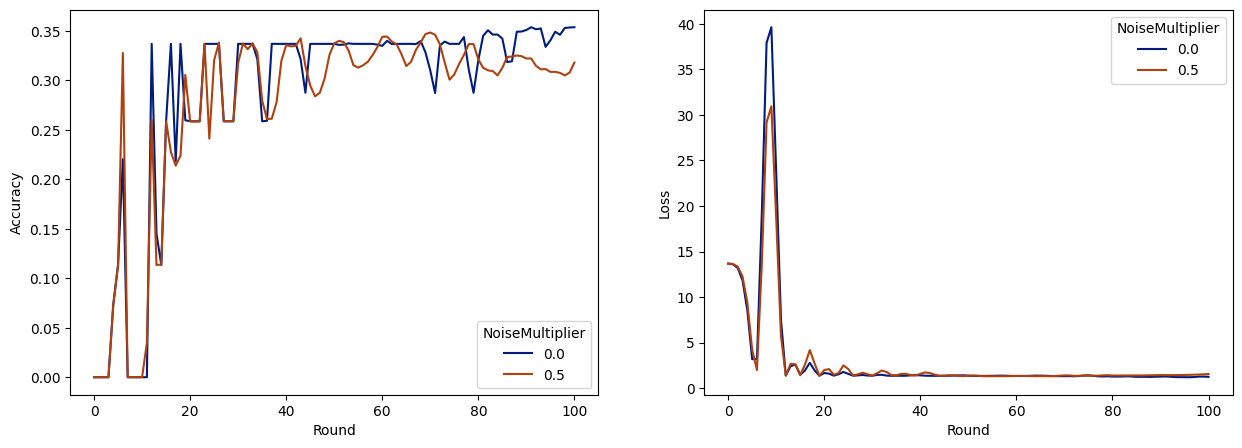

In [80]:
make_plot(data_frame)

In [64]:
aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(0.5, 10)

learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
    recommender_model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
    model_aggregator=aggregation_factory
)

In [65]:
eval_process = tff.learning.build_federated_evaluation(recommender_model_fn)

In [66]:
state = learning_process.initialize()

In [67]:
federated_train_data = np.random.choice(tf_data, size=50, replace=False).tolist()

In [68]:
result = learning_process.next(state, federated_train_data)

2022-12-16 19:49:13.569357: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 19:49:14.247925: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 19:49:14.881364: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 19:49:15.805933: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 19:49:16.102012: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 19:49:16.941533: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [37]:
result.state

LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[ 0.03228056,  0.0478077 , -0.00790657, ...,  0.01817701,
        -0.02632629,  0.03172901],
       [ 0.04264775,  0.00482096, -0.04230418, ...,  0.03922444,
        -0.03100274,  0.01343915],
       [ 0.04009292,  0.01872099,  0.02247474, ..., -0.01242683,
        -0.02513264, -0.00428354],
       ...,
       [ 0.03693977,  0.04087574, -0.0293778 , ...,  0.0086939 ,
         0.02746089,  0.00239646],
       [ 0.0095252 , -0.01781235, -0.02081897, ...,  0.04655253,
         0.03169299, -0.03490096],
       [ 0.04084032,  0.03827421,  0.02705025, ..., -0.03415472,
        -0.03829827, -0.02238796]], dtype=float32), array([[-0.05319795,  0.01619462, -0.00884012, ..., -0.04450921,
         0.01106738,  0.00961381],
       [ 0.01637965, -0.0310604 , -0.01296948, ..., -0.04938436,
        -0.01131445,  0.03764131],
       [ 0.00251416, -0.01893498, -0.0154712 , ...,  0.00264826,
        -0.05874651, -0.01098036],
   

In [41]:
metrics = eval_process(learning_process.get_model_weights(result.state), tf_data[:5])['eval']

2022-12-16 18:12:39.735735: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 18:12:47.033784: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 18:12:49.182161: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 18:12:49.837186: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 18:12:51.627869: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 18:12:54.781378: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-16 18:12:54.899297: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [23]:
train_datasets, val_datasets, test_datasets = split_tf_datasets(
    tf_datasets, train_fraction=0.8, val_fraction=0.1
)

In [8]:
data_frame = pd.DataFrame()
rounds = 100
clients_per_round = 50

for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.08238637), ('loss', 2.4529567), ('num_examples', 40832), ('num_batches', 319)])


KeyboardInterrupt: 